In [1]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d kmader/food41
! unzip food41.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/tacos/1026681.jpg  
  inflating: images/tacos/1030289.jpg  
  inflating: images/tacos/1033196.jpg  
  inflating: images/tacos/1036030.jpg  
  inflating: images/tacos/1042175.jpg  
  inflating: images/tacos/1044043.jpg  
  inflating: images/tacos/1058697.jpg  
  inflating: images/tacos/1059239.jpg  
  inflating: images/tacos/1059326.jpg  
  inflating: images/tacos/1066762.jpg  
  inflating: images/tacos/1070967.jpg  
  inflating: images/tacos/1073468.jpg  
  inflating: images/tacos/1075296.jpg  
  inflating: images/tacos/1085243.jpg  
  inflating: images/tacos/108529.jpg  
  inflating: images/tacos/1086014.jpg  
  inflating: images/tacos/108945.jpg  
  inflating: images/tacos/1089575.jpg  
  inflating: images/tacos/1091159.jpg  
  inflating: images/tacos/1101369.jpg  
  inflating: images/tacos/1109058.jpg  
  inflating: images/tacos/1109744.jpg  
  inflating: images/tacos/1119371.jpg  
  inflating: images/tacos/11237

In [5]:
! pip install higher

Using device: cuda


 20%|██        | 100/500 [00:34<02:44,  2.43it/s]

Episode 100/500, Query Loss: 1.6126


 40%|████      | 200/500 [01:07<01:33,  3.22it/s]

Episode 200/500, Query Loss: 1.5943


 60%|██████    | 300/500 [01:40<01:01,  3.25it/s]

Episode 300/500, Query Loss: 1.5726


 80%|████████  | 400/500 [02:13<00:36,  2.72it/s]

Episode 400/500, Query Loss: 1.5917


100%|██████████| 500/500 [02:45<00:00,  3.02it/s]


Episode 500/500, Query Loss: 1.5812


100%|██████████| 100/100 [00:31<00:00,  3.17it/s]


Test Accuracy: 20.97%


100%|██████████| 100/100 [00:30<00:00,  3.24it/s]


Test Accuracy: 20.20%


100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Test Accuracy: 20.45%


100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Test Accuracy: 20.16%


100%|██████████| 100/100 [00:30<00:00,  3.27it/s]


Test Accuracy: 20.59%


100%|██████████| 100/100 [00:31<00:00,  3.18it/s]


Test Accuracy: 20.72%


100%|██████████| 100/100 [00:30<00:00,  3.27it/s]


Test Accuracy: 20.77%


100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


Test Accuracy: 20.32%


100%|██████████| 100/100 [00:30<00:00,  3.26it/s]


Test Accuracy: 20.91%


100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


Test Accuracy: 20.95%


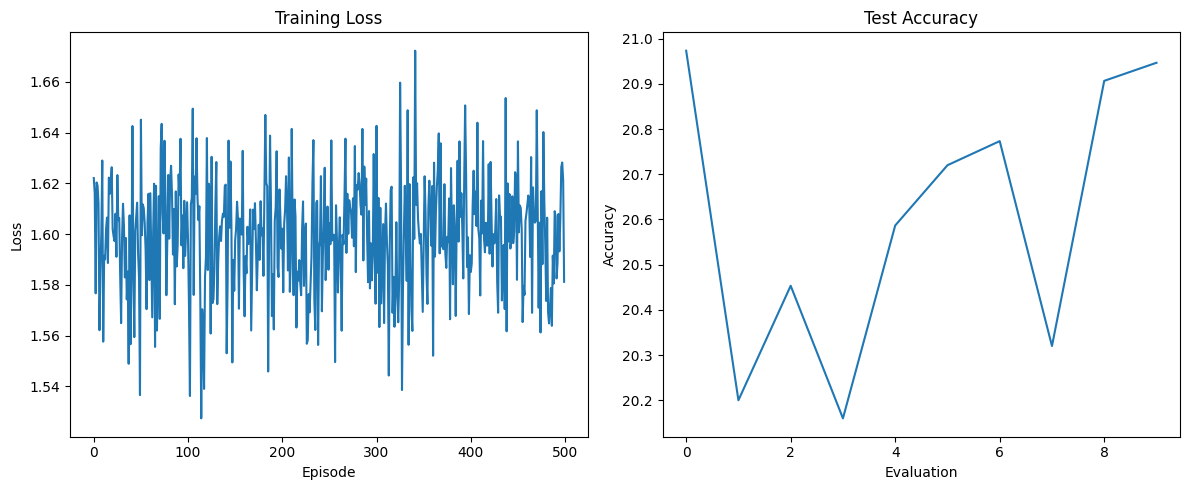

Final Average Test Accuracy: 20.60%


In [8]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import higher
import matplotlib.pyplot as plt

# Feature extractor
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(128 * 8 * 8, 128)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        return x

# Meta-learning model
class MetaLearningModel(nn.Module):
    def __init__(self, feature_extractor, feature_dim, n_way):
        super(MetaLearningModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.classifier = nn.Linear(feature_dim, n_way)

    def forward(self, x):
        features = self.feature_extractor(x)
        outputs = self.classifier(features)
        return outputs

# Few-shot dataset class
class EnhancedFewShotDataset(Dataset):
    def __init__(self, root_dir, transform=None, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.root_dir = root_dir
        self.transform = transform
        self.device = device
        self.classes = os.listdir(root_dir)
        self.class_to_images = {
            cls: [os.path.join(root_dir, cls, img) for img in os.listdir(os.path.join(root_dir, cls))]
            for cls in self.classes
        }

    def get_episode(self, n_way, k_shot, k_query):
        selected_classes = random.sample(self.classes, n_way)
        support_imgs, query_imgs, support_labels, query_labels = [], [], [], []

        for i, cls in enumerate(selected_classes):
            images = random.sample(self.class_to_images[cls], k_shot + k_query)
            support_imgs.extend(images[:k_shot])
            query_imgs.extend(images[k_shot:])
            support_labels.extend([i] * k_shot)
            query_labels.extend([i] * k_query)

        support_imgs = torch.stack([self.load_image(img) for img in support_imgs]).to(self.device)
        query_imgs = torch.stack([self.load_image(img) for img in query_imgs]).to(self.device)
        support_labels = torch.tensor(support_labels, device=self.device)
        query_labels = torch.tensor(query_labels, device=self.device)

        return support_imgs, support_labels, query_imgs, query_labels

    def load_image(self, img_path):
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# MAML training
def maml_train(model, dataset, optimizer, device, n_way=5, k_shot=5, k_query=15, num_episodes=1000, inner_lr=0.01, inner_steps=1):
    model.train()
    losses = []

    for episode in tqdm(range(num_episodes)):
        optimizer.zero_grad()
        support_imgs, support_labels, query_imgs, query_labels = dataset.get_episode(n_way, k_shot, k_query)

        inner_optimizer = optim.SGD(model.parameters(), lr=inner_lr)

        with higher.innerloop_ctx(model, inner_optimizer, copy_initial_weights=True, track_higher_grads=True) as (fmodel, diffopt):
            # Inner loop
            for _ in range(inner_steps):
                support_preds = fmodel(support_imgs)
                support_loss = F.cross_entropy(support_preds, support_labels)
                diffopt.step(support_loss)

            # Outer loop
            query_preds = fmodel(query_imgs)
            query_loss = F.cross_entropy(query_preds, query_labels)

            query_loss.backward()
            optimizer.step()

            losses.append(query_loss.item())

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}/{num_episodes}, Query Loss: {query_loss.item():.4f}")

    return losses

# MAML evaluation
def maml_evaluate(model, dataset, device, n_way=5, k_shot=5, k_query=15, num_episodes=100, inner_lr=0.01, inner_steps=1):
    model.eval()
    correct = 0
    total = 0

    for _ in tqdm(range(num_episodes)):
        support_imgs, support_labels, query_imgs, query_labels = dataset.get_episode(n_way, k_shot, k_query)

        inner_optimizer = optim.SGD(model.parameters(), lr=inner_lr)

        with higher.innerloop_ctx(model, inner_optimizer, track_higher_grads=False) as (fmodel, diffopt):
            # Adapt the model on the support set
            for _ in range(inner_steps):
                support_preds = fmodel(support_imgs)
                support_loss = F.cross_entropy(support_preds, support_labels)
                diffopt.step(support_loss)

            # Evaluate on query set
            with torch.no_grad():
                query_preds = fmodel(query_imgs)
                _, predicted = torch.max(query_preds.data, 1)
                total += query_labels.size(0)
                correct += (predicted == query_labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Main script
if __name__ == "__main__":
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Setup dataset
    data_path = "/content/images"  # Update this path
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    dataset = EnhancedFewShotDataset(data_path, transform=transform, device=device)

    # Initialize model
    feature_extractor = FeatureExtractor()
    model = MetaLearningModel(feature_extractor, feature_dim=128, n_way=5)
    model = model.to(device)

    # Setup optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training
    losses = maml_train(model, dataset, optimizer, device, num_episodes=500)

    # Evaluation
    accuracies = []
    for _ in range(10):
        accuracy = maml_evaluate(model, dataset, device)
        accuracies.append(accuracy)
        print(f"Test Accuracy: {accuracy:.2f}%")

    # Plot results
    plot_results(losses, accuracies)

    print(f"Final Average Test Accuracy: {np.mean(accuracies):.2f}%")

    # Save the model
    torch.save(model.state_dict(), "maml_model.pth")